In [1]:
!pip install librosa

In [2]:
import IPython.display as ipd
import numpy as np
import os

In [3]:
import librosa
import librosa.display
import pandas as pd

In [4]:
metadata = pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')

In [6]:
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [9]:
### Imbalance Check

metadata['class'].value_counts()

jackhammer          1000
street_music        1000
dog_bark            1000
children_playing    1000
drilling            1000
air_conditioner     1000
engine_idling       1000
siren                929
car_horn             429
gun_shot             374
Name: class, dtype: int64

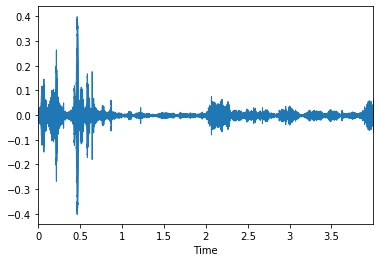

In [12]:
data, sample_rate = librosa.load('UrbanSound8K/196085-2-0-3.wav')

librosa.display.waveplot(data, sr=sample_rate)

ipd.Audio('UrbanSound8K/196085-2-0-3.wav')

In [16]:
data

array([-0.01612404, -0.02226107, -0.01091002, ...,  0.04742792,
        0.04605652,  0.04776508], dtype=float32)

In [14]:
from scipy.io import wavfile as wav

In [15]:
sci_sample_rate, sci_wav_audio = wav.read('UrbanSound8K/196085-2-0-3.wav')

In [17]:
sci_wav_audio

array([[-707, -695],
       [-730, -737],
       [-680, -677],
       ...,
       [1573, 1400],
       [1594, 1373],
       [1717, 1368]], dtype=int16)

# Extract Features MFCC

In [5]:
mfccs = librosa.feature.mfcc(y=data, sr=sample_rate, n_mfcc=40)

NameError: name 'data' is not defined

In [19]:
print(mfccs.shape)

(40, 173)


In [6]:
audio_data_path = 'UrbanSound8K/audio'

In [7]:
def feature_extraction(file):
    audio_data, sample_rate = librosa.load(file_name, res_type='kaiser_fast')
    mfccs_feature = librosa.feature.mfcc(y=audio_data, sr=sample_rate, n_mfcc=40)
    mfccs_scaled = np.mean(mfccs_feature.T, axis=0)
    
    return mfccs_scaled

In [8]:
from tqdm import tqdm

extracted_features = []

for index, row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_data_path),'fold'+str(row['fold'])+'/',str(row['slice_file_name']))
    class_label = row['class']
    data = feature_extraction(file_name)
    extracted_features.append([data, class_label])

8732it [06:24, 22.73it/s]


In [9]:
extracted_features_df = pd.DataFrame(extracted_features, columns = ['features', 'class'])

In [10]:
extracted_features_df.head()

,features,class
0,"[-215.79301, 71.66612, -131.81377, -52.09133, ...",dog_bark
1,"[-424.68677, 110.56227, -54.148235, 62.01074, ...",children_playing
2,"[-459.56467, 122.800354, -47.92471, 53.265697,...",children_playing
3,"[-414.55377, 102.896904, -36.66495, 54.18041, ...",children_playing
4,"[-447.397, 115.0954, -53.809113, 61.60859, 1.6...",children_playing


In [11]:
X = np.array(extracted_features_df['features'].tolist())
y = np.array(extracted_features_df['class'].tolist())

In [14]:
X.shape

(8732, 40)

In [15]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

In [16]:
labelEncode = LabelEncoder()

In [17]:
y = to_categorical(labelEncode.fit_transform(y))

In [18]:
y.shape

(8732, 10)

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=19)

# Model Creation 

In [22]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout,Dense,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [23]:
num_label = y.shape[1]

In [25]:
model = Sequential()
# First Layer

model.add(Dense(100, input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Second Layer

model.add(Dense(250))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Third Layer

model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Final Layer

model.add(Dense(num_label))
model.add(Activation('softmax'))


In [27]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 100)               4100      
_________________________________________________________________
activation (Activation)      (None, 100)               0         
_________________________________________________________________
dropout (Dropout)            (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 250)               25250     
_________________________________________________________________
activation_1 (Activation)    (None, 250)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [28]:
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [29]:
# Training Model

from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime

num_epoch = 200
batchsize = 32

checkpoint = ModelCheckpoint(filepath='saved_model/audio_class.hdf5', verbose=1, save_best_only=True)
start = datetime.now()


model.fit(X_train,y_train, batch_size= batchsize, epochs=num_epoch, validation_data=(X_val,y_val), callbacks=[checkpoint])

Epoch 1/200
205/205 [==============================] - 1s 3ms/step - loss: 25.3625 - accuracy: 0.1055 - val_loss: 2.2927 - val_accuracy: 0.1090

Epoch 00001: val_loss improved from inf to 2.29270, saving model to saved_model/audio_class.hdf5
Epoch 2/200
205/205 [==============================] - 0s 2ms/step - loss: 2.6028 - accuracy: 0.1270 - val_loss: 2.2789 - val_accuracy: 0.1067

Epoch 00002: val_loss improved from 2.29270 to 2.27886, saving model to saved_model/audio_class.hdf5
Epoch 3/200
205/205 [==============================] - 0s 2ms/step - loss: 2.3326 - accuracy: 0.1152 - val_loss: 2.2684 - val_accuracy: 0.1104

Epoch 00003: val_loss improved from 2.27886 to 2.26838, saving model to saved_model/audio_class.hdf5
Epoch 4/200
205/205 [==============================] - 1s 4ms/step - loss: 2.2955 - accuracy: 0.1135 - val_loss: 2.2194 - val_accuracy: 0.1159

Epoch 00004: val_loss improved from 2.26838 to 2.21940, saving model to saved_model/audio_class.hdf5
Epoch 5/200
205/205 [==

Epoch 35/200
205/205 [==============================] - 0s 2ms/step - loss: 1.3408 - accuracy: 0.5506 - val_loss: 1.1115 - val_accuracy: 0.6482

Epoch 00035: val_loss improved from 1.12345 to 1.11150, saving model to saved_model/audio_class.hdf5
Epoch 36/200
205/205 [==============================] - 0s 2ms/step - loss: 1.2861 - accuracy: 0.5644 - val_loss: 1.1221 - val_accuracy: 0.6427

Epoch 00036: val_loss did not improve from 1.11150
Epoch 37/200
205/205 [==============================] - 0s 1ms/step - loss: 1.3283 - accuracy: 0.5476 - val_loss: 1.1068 - val_accuracy: 0.6390

Epoch 00037: val_loss improved from 1.11150 to 1.10675, saving model to saved_model/audio_class.hdf5
Epoch 38/200
205/205 [==============================] - 0s 2ms/step - loss: 1.2819 - accuracy: 0.5541 - val_loss: 1.0786 - val_accuracy: 0.6610

Epoch 00038: val_loss improved from 1.10675 to 1.07863, saving model to saved_model/audio_class.hdf5
Epoch 39/200
205/205 [==============================] - 0s 2ms/ste

205/205 [==============================] - 0s 2ms/step - loss: 1.0574 - accuracy: 0.6476 - val_loss: 0.8578 - val_accuracy: 0.7371

Epoch 00071: val_loss did not improve from 0.82659
Epoch 72/200
205/205 [==============================] - 0s 1ms/step - loss: 1.0176 - accuracy: 0.6654 - val_loss: 0.8378 - val_accuracy: 0.7302

Epoch 00072: val_loss did not improve from 0.82659
Epoch 73/200
205/205 [==============================] - 0s 2ms/step - loss: 1.0354 - accuracy: 0.6578 - val_loss: 0.8317 - val_accuracy: 0.7398

Epoch 00073: val_loss did not improve from 0.82659
Epoch 74/200
205/205 [==============================] - 0s 2ms/step - loss: 0.9911 - accuracy: 0.6724 - val_loss: 0.8250 - val_accuracy: 0.7503

Epoch 00074: val_loss improved from 0.82659 to 0.82504, saving model to saved_model/audio_class.hdf5
Epoch 75/200
205/205 [==============================] - 0s 2ms/step - loss: 1.0210 - accuracy: 0.6548 - val_loss: 0.8309 - val_accuracy: 0.7407

Epoch 00075: val_loss did not impr

205/205 [==============================] - 0s 2ms/step - loss: 0.9400 - accuracy: 0.6875 - val_loss: 0.7332 - val_accuracy: 0.7705

Epoch 00110: val_loss improved from 0.74386 to 0.73323, saving model to saved_model/audio_class.hdf5
Epoch 111/200
205/205 [==============================] - 0s 2ms/step - loss: 0.9263 - accuracy: 0.6825 - val_loss: 0.7395 - val_accuracy: 0.7737

Epoch 00111: val_loss did not improve from 0.73323
Epoch 112/200
205/205 [==============================] - 0s 2ms/step - loss: 0.9350 - accuracy: 0.6840 - val_loss: 0.7306 - val_accuracy: 0.7613

Epoch 00112: val_loss improved from 0.73323 to 0.73058, saving model to saved_model/audio_class.hdf5
Epoch 113/200
205/205 [==============================] - 0s 2ms/step - loss: 0.9415 - accuracy: 0.6949 - val_loss: 0.7316 - val_accuracy: 0.7742

Epoch 00113: val_loss did not improve from 0.73058
Epoch 114/200
205/205 [==============================] - 0s 2ms/step - loss: 0.9322 - accuracy: 0.6793 - val_loss: 0.7288 - va

205/205 [==============================] - 0s 2ms/step - loss: 0.9038 - accuracy: 0.6996 - val_loss: 0.7068 - val_accuracy: 0.7801

Epoch 00149: val_loss did not improve from 0.68423
Epoch 150/200
205/205 [==============================] - 0s 2ms/step - loss: 0.8846 - accuracy: 0.7045 - val_loss: 0.7470 - val_accuracy: 0.7623

Epoch 00150: val_loss did not improve from 0.68423
Epoch 151/200
205/205 [==============================] - 0s 2ms/step - loss: 0.8917 - accuracy: 0.7088 - val_loss: 0.7118 - val_accuracy: 0.7732

Epoch 00151: val_loss did not improve from 0.68423
Epoch 152/200
205/205 [==============================] - 0s 2ms/step - loss: 0.8497 - accuracy: 0.7153 - val_loss: 0.7021 - val_accuracy: 0.7829

Epoch 00152: val_loss did not improve from 0.68423
Epoch 153/200
205/205 [==============================] - 0s 2ms/step - loss: 0.8906 - accuracy: 0.6984 - val_loss: 0.6789 - val_accuracy: 0.7893

Epoch 00153: val_loss improved from 0.68423 to 0.67888, saving model to saved_mo

205/205 [==============================] - 0s 1ms/step - loss: 0.8649 - accuracy: 0.7082 - val_loss: 0.6683 - val_accuracy: 0.7897

Epoch 00190: val_loss did not improve from 0.66546
Epoch 191/200
205/205 [==============================] - 0s 2ms/step - loss: 0.8659 - accuracy: 0.7178 - val_loss: 0.6716 - val_accuracy: 0.7994

Epoch 00191: val_loss did not improve from 0.66546
Epoch 192/200
205/205 [==============================] - 0s 2ms/step - loss: 0.8823 - accuracy: 0.7146 - val_loss: 0.6703 - val_accuracy: 0.7994

Epoch 00192: val_loss did not improve from 0.66546
Epoch 193/200
205/205 [==============================] - 0s 2ms/step - loss: 0.8509 - accuracy: 0.7103 - val_loss: 0.6558 - val_accuracy: 0.8003

Epoch 00193: val_loss improved from 0.66546 to 0.65581, saving model to saved_model/audio_class.hdf5
Epoch 194/200
205/205 [==============================] - 0s 2ms/step - loss: 0.8561 - accuracy: 0.7212 - val_loss: 0.6736 - val_accuracy: 0.7939

Epoch 00194: val_loss did not 

In [30]:
val_accu = model.evaluate(X_val,y_val,verbose=0)
print(val_accu[1])

0.7979844212532043


# Testing the Model

In [63]:
filename = 'UrbanSound8K/dog_bark.wav'

In [64]:
data,sample = librosa.load(filename, res_type='kaiser_fast')
mfcc_feature_unscaled = librosa.feature.mfcc(y = data, sr=sample, n_mfcc=40)
mfcc_feature_new = np.mean(mfcc_feature_unscaled.T, axis = 0)

In [65]:
mfcc_feature_new = mfcc_feature_new.reshape(1,-1)

In [66]:
prediction_label = model.predict_classes(mfcc_feature_new)

/Users/saujanya/opt/anaconda3/lib/python3.7/site-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


In [67]:
prediction_class = labelEncode.inverse_transform(prediction_label)

In [68]:
prediction_class

array(['dog_bark'], dtype='<U16')

In [75]:
def call_for_test(file):
    audio, sample_r = librosa.load(file, res_type='kaiser_fast')
    mfcc_feature = librosa.feature.mfcc(y=audio, sr=sample_r, n_mfcc=40)
    mfcc_scaled = np.mean(mfcc_feature.T, axis = 0)
    mfcc_scaled = mfcc_scaled.reshape(1,-1)
    p_label = model.predict_classes(mfcc_scaled)
    p_class = labelEncode.inverse_transform(p_label)
    return p_class

In [80]:
file = 'UrbanSound8K/child.wav'
predict = call_for_test(file)

In [81]:
predict

array(['children_playing'], dtype='<U16')